In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns, numpy as np, matplotlib.pyplot as plt
import time
import numpy as np
import os
import pandas as pd
from skimage import io
import cv2
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()

In [ ]:
!unzip '/content/drive/MyDrive/CSE499/Final Models/Selected Models/FinalMerged.zip'

Streaming output truncated to the last 5000 lines.
  inflating: FinalMerged/test/Blast/Blast_0098.jpg  
  inflating: FinalMerged/test/Blast/Blast_0099.jpg  
  inflating: FinalMerged/test/Blast/Blast_0100.jpg  
  inflating: FinalMerged/test/Blast/Blast_0101.jpg  
  inflating: FinalMerged/test/Blast/Blast_0102.jpg  
  inflating: FinalMerged/test/Blast/Blast_0103.jpg  
  inflating: FinalMerged/test/Blast/Blast_0104.jpg  
  inflating: FinalMerged/test/Blast/Blast_0105.jpg  
  inflating: FinalMerged/test/Blast/Blast_0106.jpg  
  inflating: FinalMerged/test/Blast/Blast_0107.jpg  
  inflating: FinalMerged/test/Blast/Blast_0108.jpg  
  inflating: FinalMerged/test/Blast/Blast_0109.jpg  
  inflating: FinalMerged/test/Blast/Blast_0110.jpg  
  inflating: FinalMerged/test/Blast/Blast_0111.jpg  
  inflating: FinalMerged/test/Blast/Blast_0112.jpg  
  inflating: FinalMerged/test/Blast/Blast_0113.jpg  
  inflating: FinalMerged/test/Blast/Blast_0114.jpg  
  inflating: FinalMerged/test/Blast/Blast_0115.j

In [ ]:
root_dir = '/content/FinalMerged'
train_dir = '/content/FinalMerged/train'
valid_dir = '/content/FinalMerged/validation'
test_dir = '/content/FinalMerged/test'
 
save_at = '/content/drive/MyDrive/CSE499/Final Models/Saved Models'

IMG_SIZE = 224
BATCH_SIZE = 32
LOSS_FN = 'CrossEntropyLoss'
OPTIMIZER_LIST = ['adam']
DROPOUT_LIST = [.1]
LEAENING_RATE_LIST = [.001]
EPOCHS = 100

NUM_CLASSES = len(os.listdir(train_dir)) # 5

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        model = models.resnext50_32x4d(pretrained=False)
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES)
        self.base_model = model

    def forward(self, x):
        return self.base_model(x)

In [ ]:
for OPTIMIZER in OPTIMIZER_LIST:
    for DROPOUT in DROPOUT_LIST:
        for LEAENING_RATE in LEAENING_RATE_LIST:
            transform = transforms.Compose([
                transforms.Resize((IMG_SIZE, IMG_SIZE)),
                transforms.ToTensor()
            ])

            train_loader = DataLoader(
                ImageFolder(train_dir,transform=transform),
                batch_size = BATCH_SIZE, shuffle = True
            )

            valid_loader = DataLoader(
                ImageFolder(valid_dir,transform=transform),
                batch_size = BATCH_SIZE, shuffle = True
            )


            model = Model().to(device)


            TRAINABLE_PARAMS = sum(p.numel() for p in model.parameters() if p.requires_grad)


            loss_fn = nn.CrossEntropyLoss()

            if OPTIMIZER == 'sgd':
                optimizer = optim.SGD(model.parameters(), lr = LEAENING_RATE)
            elif OPTIMIZER == 'adam':
                optimizer = optim.Adam(model.parameters(), lr = LEAENING_RATE)
            elif OPTIMIZER == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr = LEAENING_RATE)
            elif OPTIMIZER == 'Adadelta':
                optimizer = optim.Adadelta(model.parameters(), lr = LEAENING_RATE)
            elif OPTIMIZER == 'Adamax':
                optimizer = optim.Adamax(model.parameters(), lr = LEAENING_RATE)



            t_loss = 0
            t_acc = 0
            t_time = 0
            v_acc = 0
            v_time = 0

            best_valid_acc = 0.0
            for epoch in range(EPOCHS):
                train_starts = time.time()
                model.train()
                train_count, correct_preds = 0, 0
                train_loss = 0.
                for i, (images, labels) in enumerate(train_loader):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    _, preds = torch.max(outputs.data, 1)
                    train_count += labels.size(0)
                    correct_preds += (preds == labels).sum().item()
                    train_loss += loss.item() * labels.size(0)
                train_acc = (correct_preds / train_count) * 100.
                train_loss = train_loss / train_count
                train_ends = time.time()
                train_time = train_ends - train_starts


                valid_starts = time.time()
                model.eval()
                with torch.no_grad():
                    correct_preds, valid_count = 0, 0
                    for images, labels in valid_loader:
                        images = images.to(device)
                        labels = labels.to(device)
                        outputs = model(images)
                        _, preds = torch.max(outputs.data, 1)
                        valid_count += labels.size(0)
                        correct_preds += (preds == labels).sum().item()
                    valid_acc = (correct_preds / valid_count) * 100.

                    PATH = '/content/drive/MyDrive/CSE499/Final Models/Saved Models/compareRiceDenseNet121.pth'
                    if valid_acc > best_valid_acc:
                        torch.save(model.state_dict(), PATH)
                        best_valid_acc = valid_acc
                        print(valid_acc)
                        
                    valid_ends = time.time()
                    valid_time = valid_ends - valid_starts
                                                
                                                
                    t_loss = train_loss
                    t_acc = train_acc
                    t_time = train_time
                    v_acc = valid_acc
                    v_time = valid_time
                print(f'Epoch: {epoch}, Train_Accuracy: {train_acc:.2f}%, Train_Loss: {train_loss:.2f}, Train_Time: {train_time:.1f}s, Valid_Accuracy: {valid_acc:.2f}%, Valid_Time: {valid_time:.1f}s')
            

77.52545027407987
Epoch: 0, Train_Accuracy: 64.03%, Train_Loss: 1.05, Train_Time: 116.8s, Valid_Accuracy: 77.53%, Valid_Time: 17.5s
87.47063429913861
Epoch: 1, Train_Accuracy: 81.44%, Train_Loss: 0.52, Train_Time: 116.6s, Valid_Accuracy: 87.47%, Valid_Time: 17.2s
Epoch: 2, Train_Accuracy: 85.85%, Train_Loss: 0.41, Train_Time: 116.4s, Valid_Accuracy: 79.09%, Valid_Time: 16.8s
96.39780736100235
Epoch: 3, Train_Accuracy: 88.98%, Train_Loss: 0.31, Train_Time: 116.6s, Valid_Accuracy: 96.40%, Valid_Time: 17.3s
98.12059514487079
Epoch: 4, Train_Accuracy: 89.96%, Train_Loss: 0.31, Train_Time: 116.6s, Valid_Accuracy: 98.12%, Valid_Time: 17.3s
Epoch: 5, Train_Accuracy: 92.84%, Train_Loss: 0.20, Train_Time: 116.3s, Valid_Accuracy: 90.76%, Valid_Time: 16.8s
Epoch: 6, Train_Accuracy: 93.32%, Train_Loss: 0.21, Train_Time: 116.3s, Valid_Accuracy: 72.91%, Valid_Time: 16.8s
Epoch: 7, Train_Accuracy: 93.60%, Train_Loss: 0.19, Train_Time: 116.1s, Valid_Accuracy: 97.18%, Valid_Time: 16.8s
Epoch: 8, Train_

In [ ]:
model = Model().to(device)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

test_loader = DataLoader(
    ImageFolder(test_dir,transform=transform),
    batch_size = BATCH_SIZE, shuffle = True
)
PATH = '/content/drive/MyDrive/CSE499/Final Models/Saved Models/compareRiceDenseNet121.pth'
model.load_state_dict(torch.load(PATH))
model.eval()

with torch.no_grad():
    all_preds = []
    all_labels = []
    correct_preds, valid_count = 0, 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs.data, 1)
        all_preds.append(preds)
        all_labels.append(labels)
        valid_count += labels.size(0)
        correct_preds += (preds == labels).sum().item()
    valid_acc = (correct_preds / valid_count) * 100.
    print(f'validation accuracy: {valid_acc}')

validation accuracy: 99.52941176470588


In [ ]:
y_pred = []
for x in all_preds:
    for i in x:
        y_pred.append(i.detach().cpu().numpy().item())

y_pred = np.array(y_pred)

In [ ]:
y_true = []
for x in all_labels:
    for i in x:
        y_true.append(i.cpu().item())

y_true = np.array(y_true)

In [ ]:
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
cm

array([[188,   0,   0,   0,   0],
       [  2, 160,   1,   0,   0],
       [  1,   0, 186,   0,   0],
       [  0,   0,   0, 149,   0],
       [  0,   0,   0,   0, 163]])

In [ ]:
accuracy_score(y_true, y_pred)

0.9952941176470588

In [ ]:
precision_score(y_true, y_pred, average='macro')

0.9957891200268779

In [ ]:
recall_score(y_true, y_pred, average='macro')

0.9952494996883304

In [ ]:
f1_score(y_true, y_pred, average='macro')

0.9954897826876392

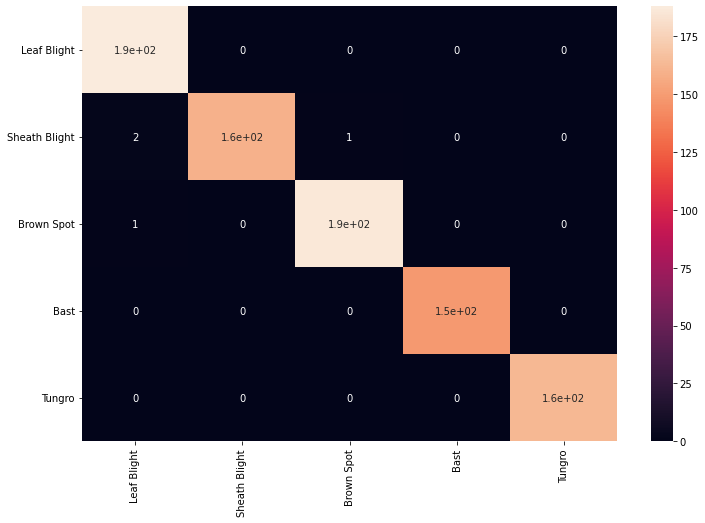

In [ ]:
plt.figure(figsize=(12, 8))
classes = [
    'Leaf Blight',
    'Sheath Blight',
    'Brown Spot',   
    'Bast',
    'Tungro'      
]
fig = sns.heatmap(cm, annot=True)
fig.set_xticklabels(classes, rotation = 90)
fig.set_yticklabels(classes, rotation = 0)
plt.show()